Abalone are a type of shellfish that are common along the coasts of most continents across the world. By cutting through the shell of an abalone, its age can be determined by counting the number of rings using a microscope, very similar to the process used for tree rings. However, the age may also be predicted by considering a number of explanatory factors, which is a much less time-consuming process.

The dataset used in this post was obtained from the UCI Machine Learning Repository (UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science), at the following link:

http://archive.ics.uci.edu/ml/datasets/Abalone

The data file from the above link was renamed as "abalone.csv". Otherwise, no initial changes were made.

This blog post is part of a series of 3 posts which will explore the use of 3 different analytical models for the same dataset:

* Multiple Regression
* Principal Component Analysis (PCA)
* Neural Networks

First, the dataset was loaded using "read_csv" from pandas (the names of the columns may be found in the above link).

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
%matplotlib inline
#Load the data from the CSV file
abaloneDF = pd.read_csv('abalone.csv',names=['Sex','Length','Diameter','Height',
                                             'Whole Weight','Shucked Weight',
                                             'Viscera Weight','Shell Weight',
                                             'Rings'])

### Data Preprocessing and Exploration

Looking at the variables in the data file, most of them are numerical, except for sex, which is categorical. If sex was binary categorical (i.e. either "male" or "female"), then it could be included directly in the regression analysis by coding "M" as -1 and "F" as 1. However, examining the data, "infant" is also included as a category, presumably because the sex cannot be easily determined when the abalone was too young, so the dichotomous approach cannot be used.

Instead, three dummy variables will be created: "Male", "Female", and "Infant". Within these three columns, a value of "1" will indicate that the abalone belongs to that category, while a value of "0" will indicate that it does not belong to the category. Note that a standard Boolean expression (e.g. "X==Y") will return either TRUE or FALSE in Python; by casting to an int, the returned value will be 0 or 1 instead, which is more appropriate for multiple regression.

In [2]:
#Transform sex into a dummy variable
abaloneDF['Male'] = (abaloneDF['Sex']=='M').astype(int)
abaloneDF['Female'] = (abaloneDF['Sex']=='F').astype(int)
abaloneDF['Infant'] = (abaloneDF['Sex']=='I').astype(int)

Now there are a total of 10 numerical explanatory factors that will be used to predict the number of rings in abalone: length, diameter, height, whole weight, shucked weight, viscera weight, shell weight, male, female, and infant. The following code will provide a summarized overview of the data.

In [3]:
abaloneDF.describe()

,Length,Diameter,Height,Whole Weight,Shucked Weight,Viscera Weight,Shell Weight,Rings,Male,Female,Infant
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000
mean,0.523992,0.407881,0.139516,0.828742,0.359367,0.180594,0.238831,9.933684,0.365813,0.312904,0.321283
std,0.120093,0.099240,0.041827,0.490389,0.221963,0.109614,0.139203,3.224169,0.481710,0.463729,0.467017
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000,0.000000,0.000000,0.000000
25%,0.450000,0.350000,0.115000,0.441500,0.186000,0.093500,0.130000,8.000000,0.000000,0.000000,0.000000
50%,0.545000,0.425000,0.140000,0.799500,0.336000,0.171000,0.234000,9.000000,0.000000,0.000000,0.000000
75%,0.615000,0.480000,0.165000,1.153000,0.502000,0.253000,0.329000,11.000000,1.000000,1.000000,1.000000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000,1.000000,1.000000,1.000000


Most of the data appears reasonable, and the counts of each variable match up. However, notice that the minimum "height" is zero; this value clearly doesn't make sense. Let's examine these instances more closely:

In [4]:
#Find the instances where the height is zero
abaloneDF[abaloneDF['Height']==0]

,Sex,Length,Diameter,Height,Whole Weight,Shucked Weight,Viscera Weight,Shell Weight,Rings,Male,Female,Infant
1257,I,0.430,0.34,0.0,0.428,0.2065,0.0860,0.1150,8,0,0,1
3996,I,0.315,0.23,0.0,0.134,0.0575,0.0285,0.3505,6,0,0,1


Other than the height, the rest of the data looks reasonable. It is likely that the height value was missing or wasn't easily measured for some reason. Given that these are only 2 instances out 4177, it is easier to simply ignore them, although if the practice was more extensive, a different solution might be required.

In [5]:
#Ignore the data for which the height is zero
abaloneDF = abaloneDF[abaloneDF['Height']>0]

I did a bit more manual examination of the data, including checking for any missing values. One of the most difficult things involved in working with another person's dataset is that "missing" values may be coded inconsistently, so it's important to check for any anomalies, such as values that are repeated more often than they should be.

A basic data exploration technique, especially when performing regression analysis, is to examine the correlation between variables. I prefer the Kendall Tau over the Pearson correlation, since it is not limited to linear correlations, but it may be useful to look at several different correlation metrics.

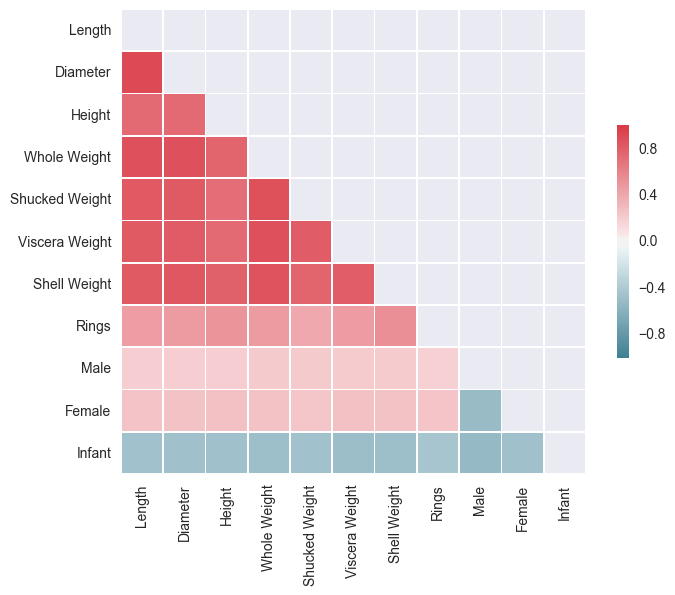

In [6]:
#This correlation coefficicent matrix follows the 
#example from the seaborn example:
#http://seaborn.pydata.org/examples/many_pairwise_correlations.html
corr = abaloneDF.corr('kendall')
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(8, 6))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1,square=True, 
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax);

Note that many of the variables are highly correlated with one another (>|0.7| correlation). This is an indication that the number of explanatory factors may be significantly reduced without affecting the final accuracy of the model. Furthermore, the correlations make sense intuitively; one would expect that the whole weight and the shucked weight would be related to one another, for example. 

### Initial Model Construction
To begin with, I'll try a multiple regression model which includes all possible explanatory factors, to find the "upper limit" of accuracy. Then, I'll reduce the number of explanatory factors until the model accuracy is significantly affected (simpler models are preferable to complicated ones). This process has some practical significance as well. For example, if the researchers were only required to measure the height and whole weight of the abalone to accurately determine the probable number of rings, it reduces the burden of their data collection.

First, as usual, the data is separated into testing and training datasets. Since the data is non-sequential, the method used to divide the data is less important than if the data were time-series (for example), so I chose random allocation, with a split of 70% training data and 30% testing data.

In [7]:
train, test = train_test_split(abaloneDF,train_size=0.7)
#The easiest way to split the independent and dependent
#variables is to "drop" the ones that we don't need for
#the X values, which are 'Rings' and 'Sex' (since we 
#transformed the 'Sex' value above)
xtrain = train.drop(['Rings','Sex'],axis=1)
ytrain = train['Rings']
xtest = test.drop(['Rings','Sex'],axis=1)
ytest = test['Rings']
regr = linear_model.LinearRegression()
regr.fit(xtrain, ytrain)
#Take a look at the regression coefficients
dict(zip(list(xtrain.columns),regr.coef_))

{'Diameter': 10.891124440244319,
 'Female': 0.2092393007306062,
 'Height': 9.7795473302049594,
 'Infant': -0.55766071653771909,
 'Length': 0.11442193544956823,
 'Male': 0.34842141580715397,
 'Shell Weight': 7.0343534592691546,
 'Shucked Weight': -21.087688081427075,
 'Viscera Weight': -11.145502003607316,
 'Whole Weight': 10.142464126255723}

Next, let's get a sense of how well the model performed. R^2 is difficult to interpret without some relative point of comparison, which we don't have yet, but the mean absolute error (MAE) is straightforward, as it is in the same original units of the data ("Number of Rings").

The following code will create a Y-Yhat plot, which compares the predicted values to the actual values. If the prediction is "perfect", the data points should fall along the y=x axis. Note that the model validation metrics must use the testing dataset, not the training dataset, due to cross-validation concerns. Performing model validation on the testing dataset ensures that the model still works correctly on data that it has never seen before; otherwise, the model might have "learned" all the eccentricities of the training data but not actually discovered the underlying relationships in the data.

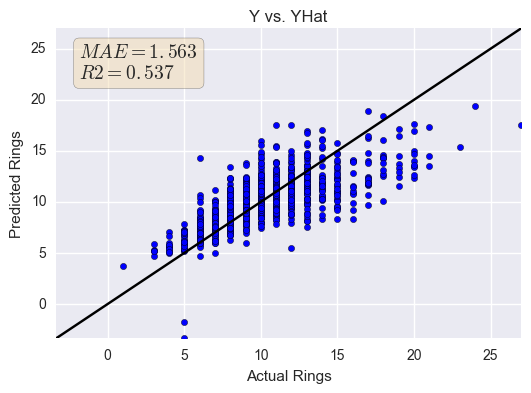

In [8]:
#This function will be used later on in the notebook as well
def plot_yyhat(ytest,ypred):
    r2 = r2_score(ytest, ypred )
    mae = mean_absolute_error(ytest, ypred)
    #This is a trick to get the scaling right, we want
    #the minimum and maximum possible values for both
    #the testing data and the predicted values
    absmin = min([ytest.min(),ypred.min()])
    absmax = max([ytest.max(),ypred.max()])
    ax = plt.axes()
    ax.scatter(ytest,ypred)
    ax.set_title('Y vs. YHat')
    ax.axis([absmin, absmax, absmin, absmax])
    ax.plot([absmin, absmax], [absmin, absmax],c="k")
    ax.set_ylabel('Predicted Rings') 
    ax.set_xlabel('Actual Rings')
    #Plot the text box
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    textStr = '$MAE=%.3f$\n$R2=%.3f$' % (mae, r2)
    ax.text(0.05, 0.95, textStr, transform=ax.transAxes, fontsize=14,
               verticalalignment='top', bbox=props);

ypred = regr.predict(xtest)
plot_yyhat(ytest,ypred)

In the above figure, the black line represents a "perfect" prediction, and the blue dots are data points from the testing dataset. Note that the prediction seems to get worse as the actual number of rings increases. 

The mean absolute error does not seem adequate. I was expecting a MAE around 0.5, which would mean that the model would be fairly close when predicting an integer number of rings. The question to ask (really, it should have been asked at the very beginning) is what target accuracy needs to be achieved before the researchers no longer need to manually count rings. 

At this point, I would begin examining other, more complicated algorithms, but for now, let's assume that the above mean absolute error is good enough. Next, we will improve the model (and the chance of overfitting) by reducing the number of explanatory factors to only those which are necessary, which may improve prediction accuracy as well if overfitting is present.

### Lasso Model Construction
Since many of the factors were highly related (according to the Kendall Tau metric calculated in a previous section), it is likely that an accuracy close to 1.66 can still be achieved with fewer explanatory factors. 

There are many algorithms which could be used for this purpose, but let's try a regularization method called Least Absolute Shrinkage and Selection Operator (LASSO). Regularization methods are designed to reduce overfitting by imposing penalties on the regression model. In this case, LASSO is a good choice because it can reduce the coefficients of unnecessary factors to zero, effectively reducing the number of explanatory factors in the model.

The following code will construct a LASSO model, using cross-validation to select an appropriate alpha, which is a required hyperparameter for the LASSO model. Essentially, the method will divide the dataset into 20 (or user-modifiable) different partitions and determine the best alpha value for each partition. Then, the average alpha across all folds will be selected.

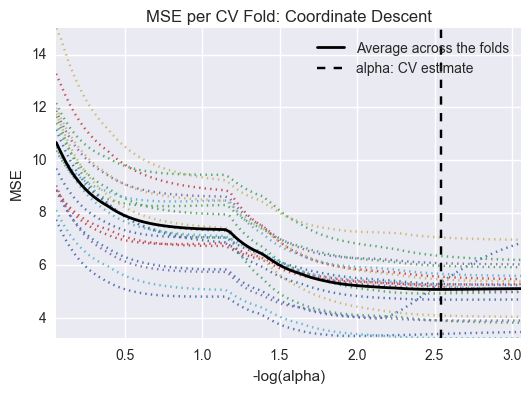

In [9]:
#Note- the regulatization path figure was originally from an example here:
#http://scikit-learn.org/stable/auto_examples/linear_model/
#plot_lasso_model_selection.html
num_cv = 20
lasso_model = linear_model.LassoCV(cv=num_cv).fit(xtrain, ytrain)
m_log_alphas = -np.log10(lasso_model.alphas_)
ax = plt.axes()
ax.plot(m_log_alphas, lasso_model.mse_path_, ':')
ax.plot(m_log_alphas, lasso_model.mse_path_.mean(axis=-1), 'k',
         label='Average across the folds', linewidth=2)
ax.axvline(-np.log10(lasso_model.alpha_), linestyle='--', color='k',
            label='alpha: CV estimate')
ax.legend()
ax.set_xlabel('-log(alpha)')
ax.set_ylabel('MSE')
ax.set_title('MSE per CV Fold: Coordinate Descent')
ax.axis('tight');

In the figure above, each colored dotted line represents a different fold from the cross-validation. The solid black line shows the average mean squared error (MSE) vs. alpha across all folds, while the dotted black line shows the selected alpha. Note that the model begins to achieve diminishing returns on MSE near the dotted black line, and hence the selected alpha makes sense.

Let's examine the new coefficients from the lasso model:

In [10]:
dict(zip(list(xtrain.columns),lasso_model.coef_))

{'Diameter': 9.5154834920619926,
 'Female': -0.0,
 'Height': 6.1212592588847006,
 'Infant': -0.81200137525616978,
 'Length': 0.18727868368787173,
 'Male': 0.10821204317831659,
 'Shell Weight': 9.0337385332799176,
 'Shucked Weight': -18.767334982643128,
 'Viscera Weight': -5.6324669219066257,
 'Whole Weight': 7.8567874731916243}

Notice that the "Female" and "Length" coefficients are now zero. The "Female" makes sense, as it is the opposite of "Male"- they essentially contain the same information (In fact, I ran this notebook multiple times, and it chose one or the other of these factors each time). The information contained in "Length" is probably adequately duplicated across similar factors, such as diameter. 

Next, let's look at the Y-Yhat plot (using the same function as defined earlier):

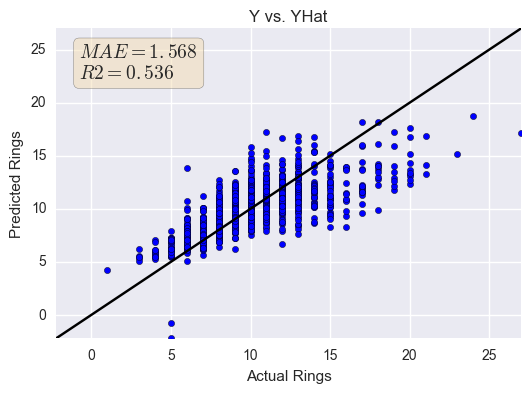

In [11]:
ypred2 = lasso_model.predict(xtest)
plot_yyhat(ytest,ypred2)

The mean absolute error was roughly the same as before, but less explanatory factors were used, the chance of overfitting is reduced, and the model is simplified. 

### Model Validation
Finally, let's validate the constructed Lasso model. First, let's look at the residuals plotted against each explanatory factor, which should show no dependency. 

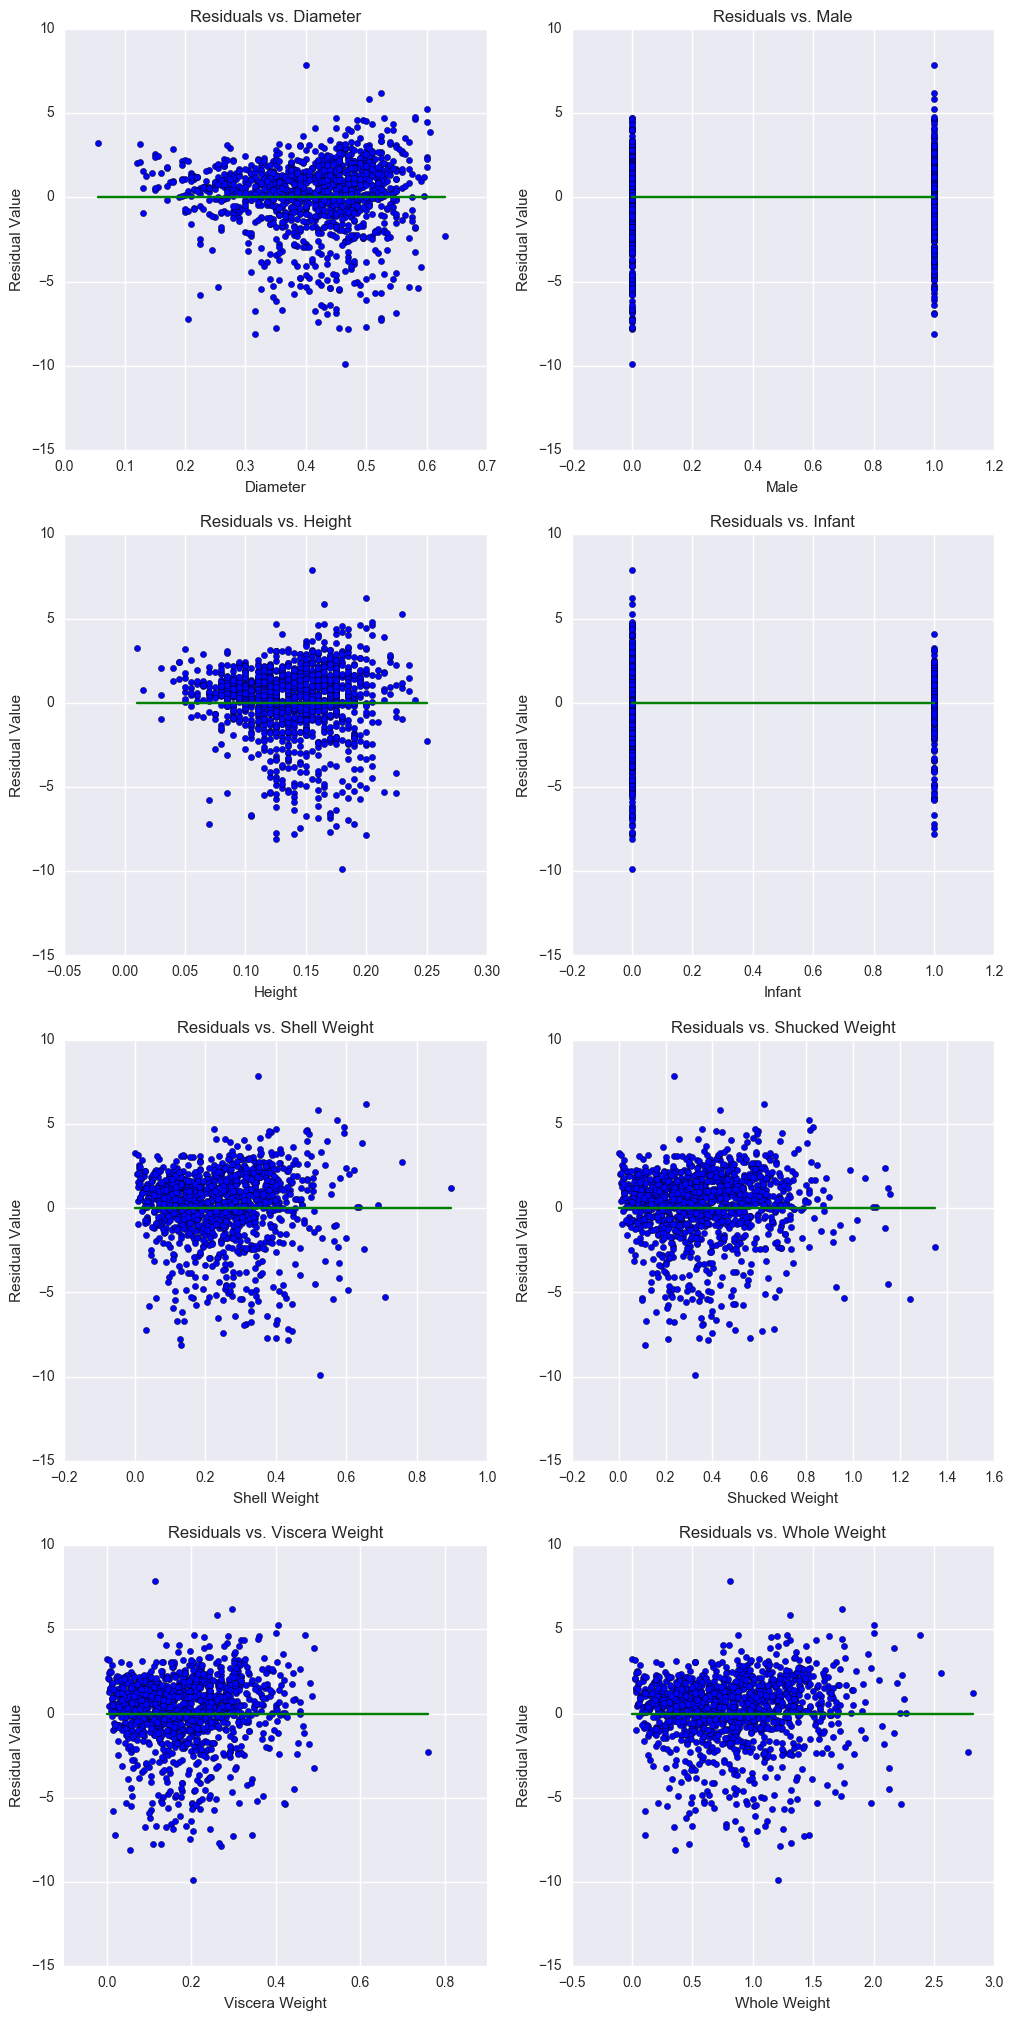

In [14]:
def plotResiduals(curAx, x, xLab, yres): 
    curAx.scatter(x,yres)
    curAx.set_title('Residuals vs. {}'.format(xLab))
    curAx.set_ylabel('Residual Value')
    curAx.set_xlabel(xLab)
    minVal, maxVal = min(x), max(x)
    curAx.plot([minVal, maxVal],[0,0],c='g')

yresid = ypred2 - ytest
f,((ax1,ax2),(ax3,ax4),(ax5,ax6),(ax7,ax8)) = plt.subplots(4,2,figsize=(12,25)) 
plotResiduals(ax1,xtest['Diameter'],'Diameter',yresid)
plotResiduals(ax2,xtest['Male'],'Male',yresid)
plotResiduals(ax3,xtest['Height'],'Height',yresid)
plotResiduals(ax4,xtest['Infant'],'Infant',yresid)
plotResiduals(ax5,xtest['Shell Weight'],'Shell Weight',yresid)
plotResiduals(ax6,xtest['Shucked Weight'],'Shucked Weight',yresid)
plotResiduals(ax7,xtest['Viscera Weight'],'Viscera Weight',yresid)
plotResiduals(ax8,xtest['Whole Weight'],'Whole Weight',yresid)

Remember that "Male" and "Infant" must either be zero or one.

The key to looking at these residual plots is to determine if there are any obvious relationships or trends. (Note- this process does not have to be done visually, of course, but during initial model construction it is important to at least look, to get a good "feel" of the results). I don't see any obvious trends in the above figures, so the model "passes" this validation check.

Let's examine the distribution of the residuals next:

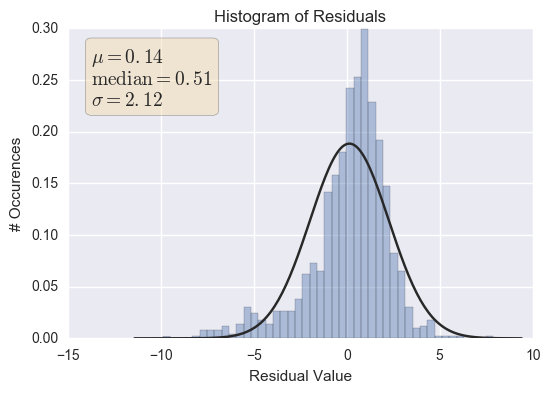

In [13]:
ax = plt.axes()
sns.distplot(yresid,ax=ax,kde=False, fit=stats.norm) 
#Plot the text box
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
textStr = '$\mu=%.2f$\n$\mathrm{median}=%.2f$\n$\sigma=%.2f$' % \
          (yresid.mean(), yresid.median(), yresid.std())
ax.text(0.05, 0.95, textStr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props);
ax.set_title('Histogram of Residuals')
ax.set_ylabel('# Occurences')
ax.set_xlabel('Residual Value');

The distribution of the residuals is approximately Gaussian, which is a good sign. If the distribution was bimodal or had a strong tail on either side, we might want to investigate futher.

Overall, the regression model performance is adequate, but we will will continue to investigate the variable dependencies in greater detail (Principal Component Analysis, post 2) or try a less interpretable but potentially more accurate model (Neural Networks, post 3).